# Fréquentation du dimanche : éléments quantitatifs

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import datetime

from kiblib.utils.db import DbConn

In [1]:
class StatDimanche():
    def __init__(self, **kwargs):
        if 'db_conn' in kwargs:
            self.db_conn = kwargs.get('db_conn')
        else:
            raise Exception("Manque l'argument 'db_conn'.")
        if 'query' in kwargs:
            self.query = kwargs.get('query')
        else:
            raise Exception("Manque l'argument 'query'.")
        if 'dimanches_str' in kwargs:
            self.dimanches_str = kwargs.get('dimanches_str')
        else:
            raise Exception("Manque l'argument 'dimanches_str'.")
        
        self.dimanches = [datetime.date.fromisoformat(d_str) for d_str in self.dimanches_str]
        self.semaines = [str(d.year) + "-" + str(d.isocalendar()[1]) for d in self.dimanches]
        
        self.df = pd.read_sql(self.query, con=self.db_conn)
        self.df['date_heure'] = pd.to_datetime(self.df['date_heure'])
        self.df['date'] = self.df['date_heure'].dt.date
        self.df['heure'] = self.df['date_heure'].dt.hour
        self.df['semaine'] = self.df['date_heure'].dt.year.astype(str) + "-" + self.df['date_heure'].dt.isocalendar().week.astype(str)
        self.df['semaine_simple'] = self.df['date_heure'].dt.isocalendar().week.astype(str)
        self.df['jour_semaine'] = self.df['date_heure'].dt.weekday
        self.df = self.df[(self.df['heure'] >= 9) & (self.df['heure'] < 19)]
        self.df = self.df[~((self.df['jour_semaine'] == 6) & (self.df['heure'] < 14))]
        self.df = self.df[~((self.df['jour_semaine'] == 6) & (self.df['heure'] > 17))]
       
        
        if 'nombre' not in self.df:
            self.df['nombre'] = 1
        
        self.df = self.df[self.df['semaine'].isin(self.semaines)]
        
        self.df_semaine = self.df.groupby([self.df['semaine']])['nombre'].sum().to_frame().reset_index()
        self.df_semaine = self.df_semaine.rename(columns={'nombre':'nombre_semaine'})

        self.df_dimanche = self.df[self.df['date'].isin(self.dimanches)]
        
    def get_df_dimanche_date(self):
        self.df_dimanche_date = self.df_dimanche.groupby(['date', 'semaine'])['nombre'].sum().to_frame().reset_index()
        self.df_dimanche_date = pd.merge(self.df_dimanche_date, self.df_semaine, on= 'semaine', how='left')
        self.df_dimanche_date['moyenne_horaire_dimanche'] = self.df_dimanche_date['nombre'] / 4 
        self.df_dimanche_date['moyenne_horaire_dimanche'] = self.df_dimanche_date['moyenne_horaire_dimanche'].round().astype(int)
        self.df_dimanche_date['moyenne_horaire_semaine'] = self.df_dimanche_date['nombre_semaine'] / 55
        self.df_dimanche_date['moyenne_horaire_semaine'] = self.df_dimanche_date['moyenne_horaire_semaine'].round().astype(int)
 
    def get_df_dimanche_date_heure(self):
        self.df_dimanche_date_heure = self.df_dimanche.groupby(['date', 'heure'])['nombre'].sum().to_frame().reset_index()
        
    def get_df_dimanche_date_usagers(self):
        self.df_dimanche_date_usagers = self.df_dimanche.groupby(['date'])['usager'].nunique().to_frame().reset_index()
        
    def get_df_moyenne(self):
        self.df_moyenne = self.df_dimanche_date[['date', 'moyenne_horaire_dimanche', 'moyenne_horaire_semaine']]
        self.df_moyenne = self.df_moyenne.set_index("date")
        self.df_moyenne = self.df_moyenne.stack().reset_index()
        self.df_moyenne = self.df_moyenne.rename(columns={'level_1':'periode', 0:'moyenne'})
        
    def get_df_semaine_mediane(self, rescale=False):
        self.df_semaine_mediane = self.df.groupby(['semaine', 'jour_semaine', 'heure'])['nombre'].sum().to_frame().reset_index()
        self.df_semaine_mediane = self.df_semaine_mediane.groupby(['jour_semaine', 'heure'])['nombre'].median().to_frame().reset_index()
        if rescale:
            to_rescale = self.df_semaine_mediane[['nombre']]
            scaler = MinMaxScaler(feature_range=(-1, 1))
            scaler.fit(to_rescale)
            to_rescale = scaler.transform(to_rescale)
            self.df_semaine_mediane['nombre'] = to_rescale
        self.df_semaine_mediane = pd.pivot_table(self.df_semaine_mediane, values='nombre', index='heure', columns='jour_semaine', aggfunc='mean')
        jours = {0: "lundi", 1:"mardi", 2:"mercredi", 3:"jeudi", 4:"vendredi", 5:"samedi", 6:"dimanche"}
        for j in self.df_semaine_mediane.columns:
            self.df_semaine_mediane = self.df_semaine_mediane.rename(columns={ j: jours[j] })

In [3]:
db_conn = DbConn().create_engine()

In [4]:
# on déclare les dimanches ouverts au format YYYY-MM-DD
dimanches_str = ['2022-09-11',
                 '2022-09-18',
                 '2022-09-25',
                 '2022-10-02',
                 '2022-10-09']

## Entrées

In [5]:
query = """
SELECT datetime as date_heure, entrees as nombre
FROM stat_entrees
WHERE YEAR(datetime) >= 2022
"""

entrees = StatDimanche(db_conn=db_conn, query=query, dimanches_str=dimanches_str)

entrees.get_df_dimanche_date()
entrees_dimanche_date = entrees.df_dimanche_date

entrees.get_df_dimanche_date_heure()
entrees_dimanche_date_heure = entrees.df_dimanche_date_heure

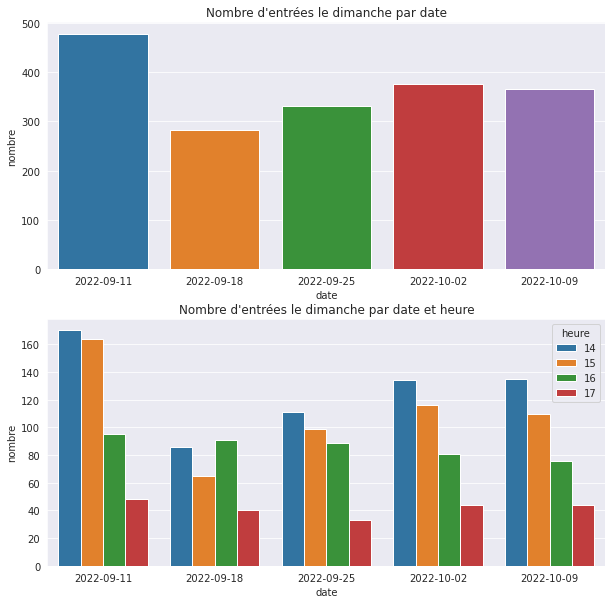

In [6]:
f, ax = plt.subplots(2, figsize=(10, 10))
#f.suptitle('Entrées')
sns.barplot(data=entrees_dimanche_date, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title("Nombre d'entrées le dimanche par date")
sns.barplot(data=entrees_dimanche_date_heure, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title("Nombre d'entrées le dimanche par date et heure")
#sns.barplot(data=entrees_moyenne, x= 'date', y='moyenne', hue='periode',ax=ax[2])
#ax[2].set_title("Comparaison entrées dimanche / semaine")
f.show()

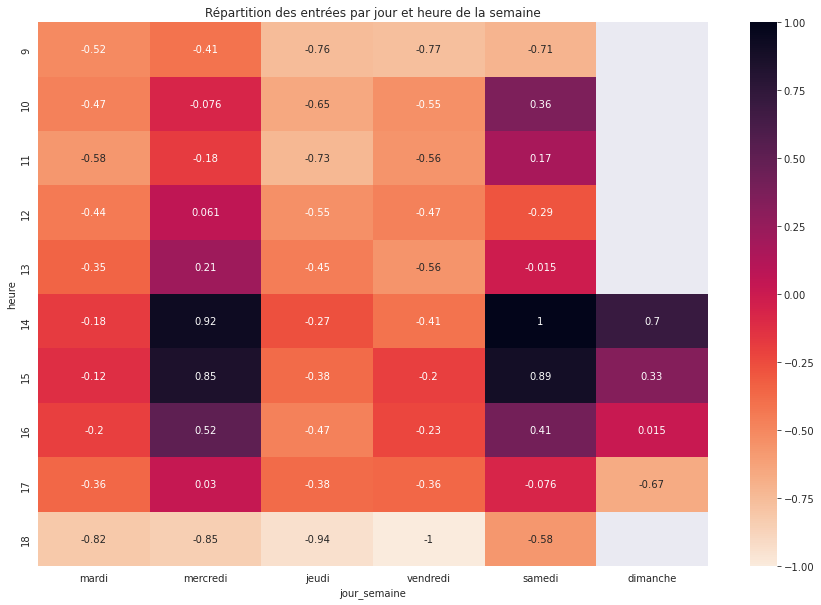

In [7]:
entrees.get_df_semaine_mediane(rescale=True)
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(entrees.df_semaine_mediane, cmap='rocket_r', annot=True, ax=ax)
ax.set_title("Répartition des entrées par jour et heure de la semaine")
f.show()

## Prêts

In [8]:
query = """
SELECT issuedate as date_heure, borrowernumber as usager
FROM stat_issues
WHERE DATE(issuedate) >= '2022-09-01' AND location NOT IN ('MED0A', 'BUS1A')
"""
prets = StatDimanche(db_conn=db_conn, query=query, dimanches_str=dimanches_str)

prets.get_df_dimanche_date()
prets_dimanche_date = prets.df_dimanche_date

prets.get_df_dimanche_date_heure()
prets_dimanche_date_heure = prets.df_dimanche_date_heure

prets.get_df_dimanche_date_usagers()
prets_dimanche_date_usagers = prets.df_dimanche_date_usagers

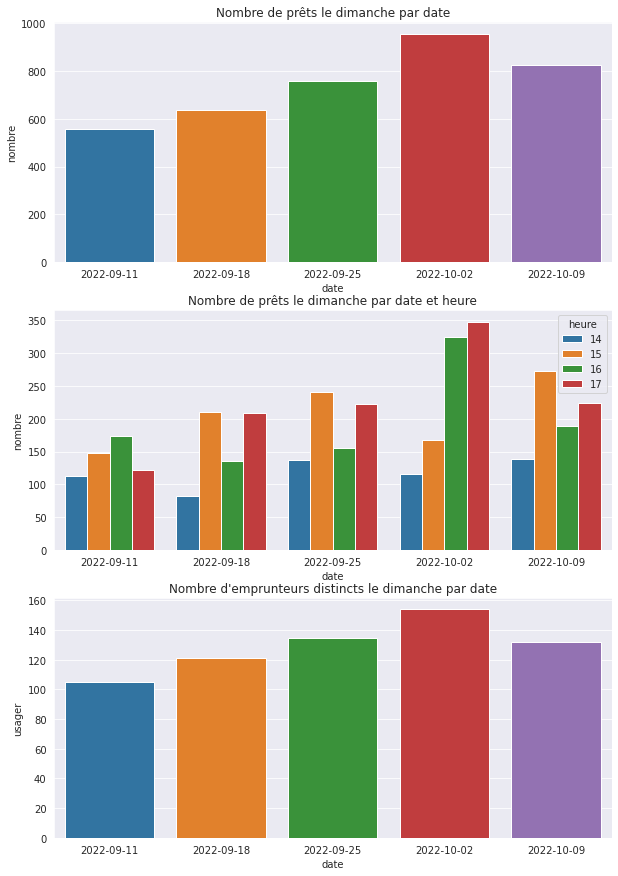

In [9]:
f, ax = plt.subplots(3, figsize=(10, 15))
#f.suptitle('Prêts')
sns.barplot(data=prets_dimanche_date, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title('Nombre de prêts le dimanche par date')
sns.barplot(data=prets_dimanche_date_heure, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title('Nombre de prêts le dimanche par date et heure')
sns.barplot(data=prets_dimanche_date_usagers, x= 'date', y='usager', ax=ax[2])
ax[2].set_title("Nombre d'emprunteurs distincts le dimanche par date")
#sns.barplot(data=prets_moyenne, x= 'date', y='moyenne', hue='periode',ax=ax[3])
#ax[3].set_title("Comparaison prêts dimanche / semaine")
f.show()

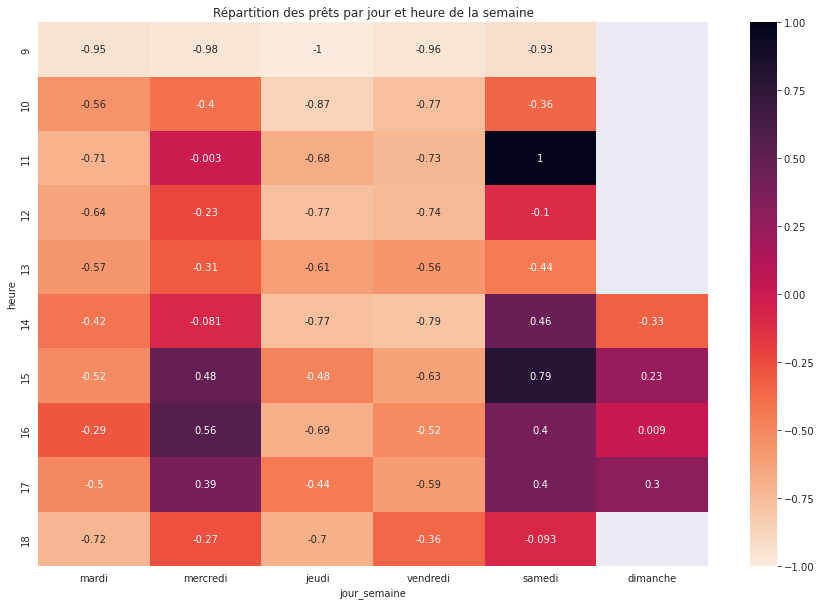

In [10]:
prets.get_df_semaine_mediane(rescale=True)
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(prets.df_semaine_mediane, cmap='rocket_r', annot=True, ax=ax)
ax.set_title("Répartition des prêts par jour et heure de la semaine")
f.show()

## Retours

In [11]:
query = """
SELECT returndate as date_heure, borrowernumber as usager
FROM stat_issues
WHERE DATE(returndate) >= '2022-09-01' AND location NOT IN ('MED0A', 'BUS1A')
"""
retours = StatDimanche(db_conn=db_conn, query=query, dimanches_str=dimanches_str)

retours.get_df_dimanche_date()
retours_dimanche_date = retours.df_dimanche_date

retours.get_df_dimanche_date_heure()
retours_dimanche_date_heure = retours.df_dimanche_date_heure

retours.get_df_dimanche_date_usagers()
retours_dimanche_date_usagers = retours.df_dimanche_date_usagers

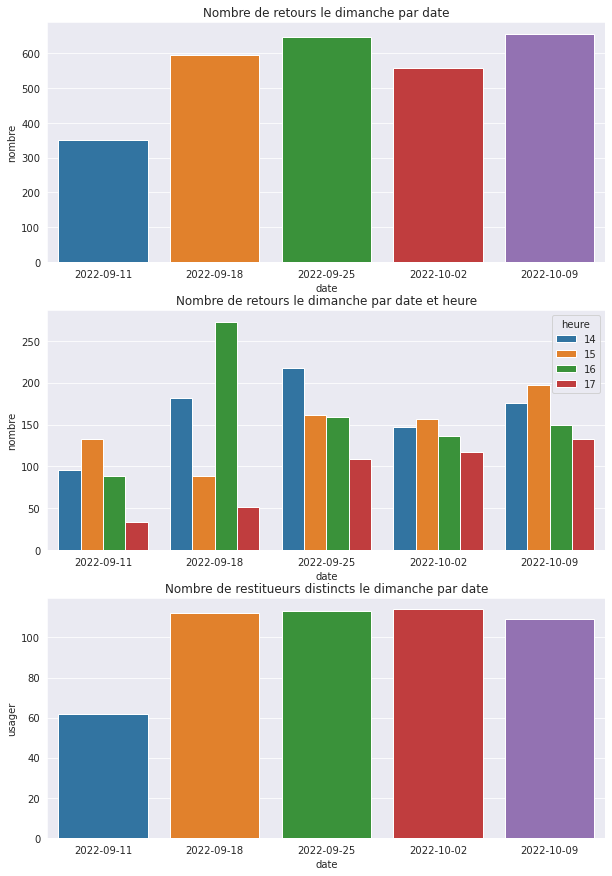

In [12]:
f, ax = plt.subplots(3, figsize=(10, 15))
#f.suptitle('retours')
sns.barplot(data=retours_dimanche_date, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title('Nombre de retours le dimanche par date')
sns.barplot(data=retours_dimanche_date_heure, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title('Nombre de retours le dimanche par date et heure')
sns.barplot(data=retours_dimanche_date_usagers, x= 'date', y='usager', ax=ax[2])
ax[2].set_title("Nombre de restitueurs distincts le dimanche par date")
#sns.barplot(data=retours_moyenne, x= 'date', y='moyenne', hue='periode',ax=ax[3])
#ax[3].set_title("Comparaison retours dimanche / semaine")
f.show()

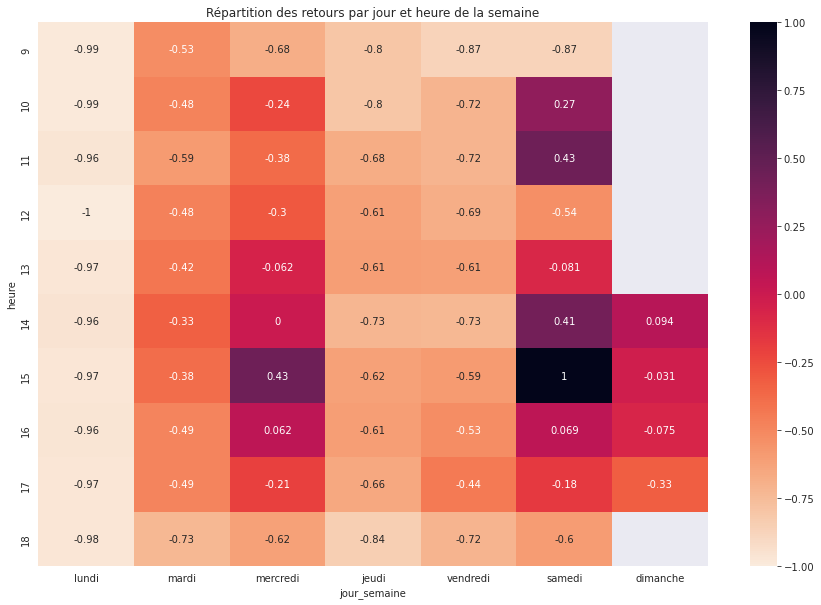

In [13]:
retours.get_df_semaine_mediane(rescale=True)
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(retours.df_semaine_mediane, cmap='rocket_r', annot=True, ax=ax)
ax.set_title("Répartition des retours par jour et heure de la semaine")
f.show()

## Connexions Webkiosk

In [14]:
query = """
SELECT heure_deb as date_heure, borrowernumber as usager
FROM stat_webkiosk
WHERE DATE(heure_deb) >= '2022-09-01'
"""

wk = StatDimanche(db_conn=db_conn, query=query, dimanches_str=dimanches_str)

wk.get_df_dimanche_date()
wk_dimanche_date = wk.df_dimanche_date

wk.get_df_dimanche_date_heure()
wk_dimanche_date_heure = wk.df_dimanche_date_heure

wk.get_df_dimanche_date_usagers()
wk_dimanche_date_usagers = wk.df_dimanche_date_usagers

wk.get_df_moyenne()
wk_moyenne = wk.df_moyenne

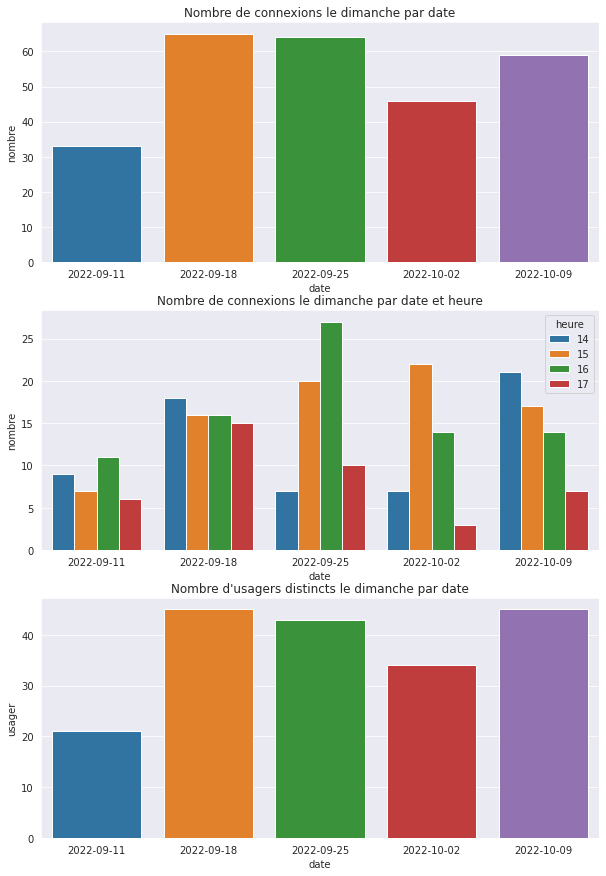

In [15]:
f, ax = plt.subplots(3, figsize=(10, 15))
#f.suptitle('Connexions aux postes informatiques')
sns.barplot(data=wk_dimanche_date, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title('Nombre de connexions le dimanche par date')
sns.barplot(data=wk_dimanche_date_heure, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title('Nombre de connexions le dimanche par date et heure')
sns.barplot(data=wk_dimanche_date_usagers, x= 'date', y='usager', ax=ax[2])
ax[2].set_title("Nombre d'usagers distincts le dimanche par date")
#sns.barplot(data=wk_moyenne, x= 'date', y='moyenne', hue='periode',ax=ax[3])
#ax[3].set_title("Comparaison connexions dimanche / semaine")
f.show()

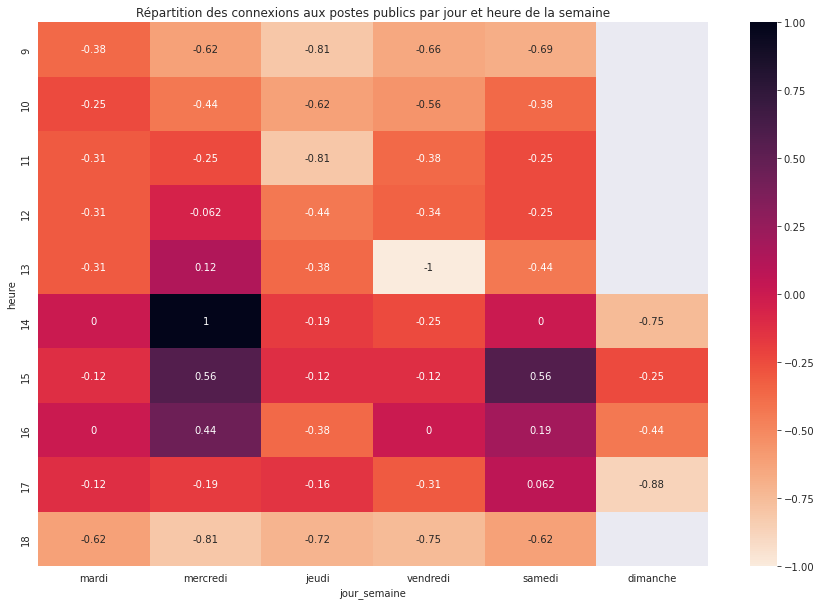

In [16]:
wk.get_df_semaine_mediane(rescale=True)
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(wk.df_semaine_mediane, cmap='rocket_r', annot=True, ax=ax)
ax.set_title("Répartition des connexions aux postes publics par jour et heure de la semaine")
f.show()

## Salle d'étude

In [17]:
query = """
SELECT datetime_entree as date_heure, borrowernumber as usager
FROM stat_freq_etude
WHERE DATE(datetime_entree) >= '2022-09-01'
"""

etude = StatDimanche(db_conn=db_conn, query=query, dimanches_str=dimanches_str)

etude.get_df_dimanche_date()
etude_dimanche_date = etude.df_dimanche_date

etude.get_df_dimanche_date_heure()
etude_dimanche_date_heure = etude.df_dimanche_date_heure

etude.get_df_dimanche_date_usagers()
etude_dimanche_date_usagers = etude.df_dimanche_date_usagers

etude.get_df_moyenne()
etude_moyenne = etude.df_moyenne

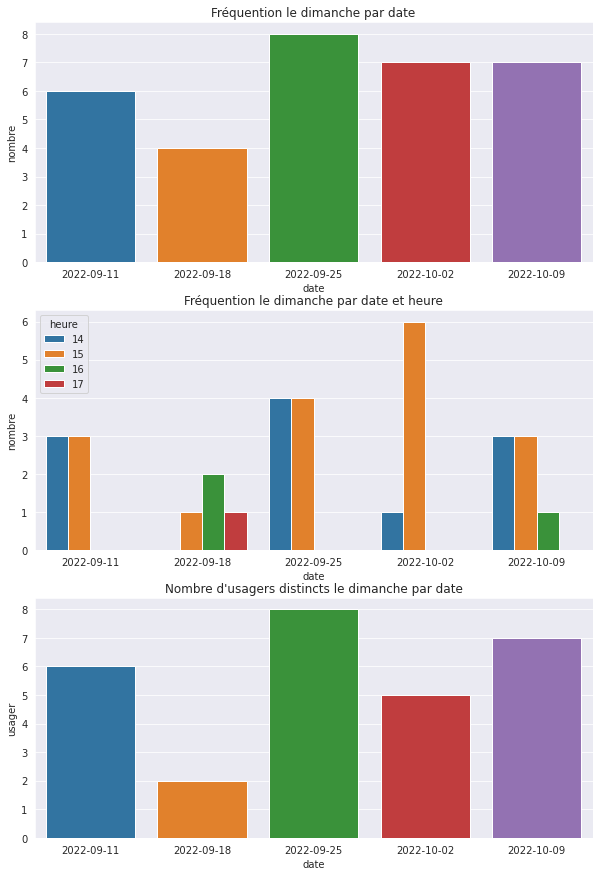

In [18]:
f, ax = plt.subplots(3, figsize=(10, 15))
#f.suptitle("Fréquention de la salle d'étude")
sns.barplot(data=etude_dimanche_date, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title('Fréquention le dimanche par date')
sns.barplot(data=etude_dimanche_date_heure, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title('Fréquention le dimanche par date et heure')
sns.barplot(data=etude_dimanche_date_usagers, x= 'date', y='usager', ax=ax[2])
ax[2].set_title("Nombre d'usagers distincts le dimanche par date")
#sns.barplot(data=etude_moyenne, x= 'date', y='moyenne', hue='periode',ax=ax[3])
#ax[3].set_title("Comparaison fréquentation dimanche / semaine")
f.show()

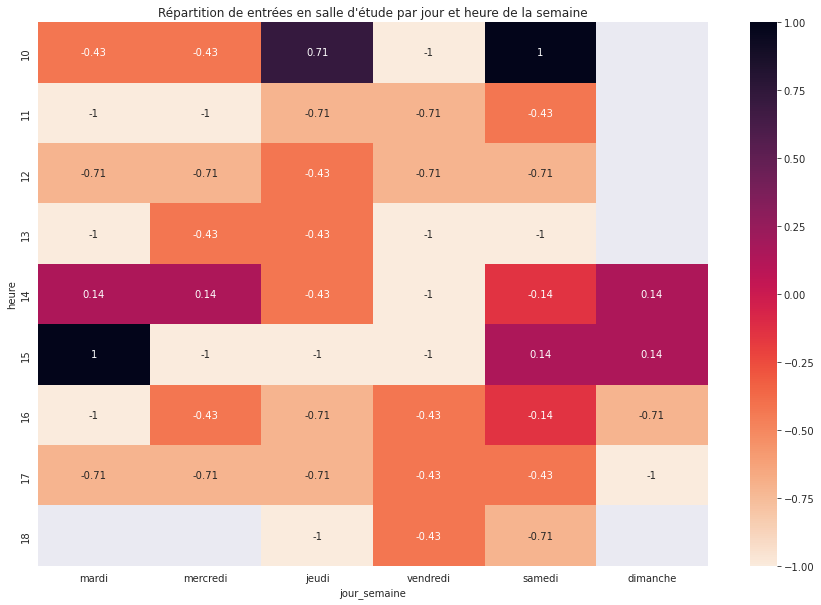

In [19]:
etude.get_df_semaine_mediane(rescale=True)
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(etude.df_semaine_mediane, cmap='rocket_r', annot=True, ax=ax)
ax.set_title("Répartition de entrées en salle d'étude par jour et heure de la semaine")
f.show()